# **🐾Dog and Cat Classification**:
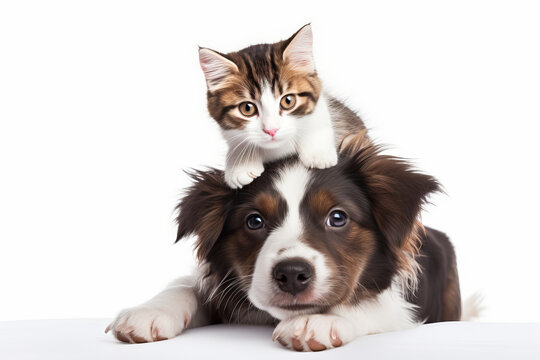


# 1.Business Problem

The goal of this project is to build a Convolutional Neural Network (CNN) model that can accurately classify images of cats and dogs.

# 2.Data Understanding

Data reading, model evaluation and installation of necessary libraries for the model.

Data set link : [Kaggle - Cat and Dog Dataset](https://www.kaggle.com/datasets/tongpython/cat-and-dog)


## 2.1 Importing the Required Libraries

In [1]:
# The data reading and processing
import cv2
import urllib
import numpy as np
import pandas as pd
import seaborn as sns
import random, os
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# Used to turn off warnings.
import warnings
warnings.filterwarnings('ignore')

# Model evaluation
from sklearn.metrics import confusion_matrix, classification_report

# Libraries to be used for the model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

## 2.2 Google Colab Identity Verification

In [2]:

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## 2.3 Downloading Data from Kaggle

In [ ]:
# Install the Kaggle package
!pip install -q kaggle

In [ ]:
#  Upload your Kaggle API key
#  your Kaggle account -> Settings -> Account -> "Create New API Token"
from google.colab import files
files.upload()  # Upload the kaggle.json file here

In [ ]:
# Move the kaggle.json file to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# You can download the dataset
!kaggle datasets download -d tongpython/cat-and-dog


Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
 97% 212M/218M [00:00<00:00, 761MB/s] 
100% 218M/218M [00:00<00:00, 773MB/s]


In [ ]:
# Unzip the file
!unzip cat-and-dog.zip -d ./cat_dog_dataset

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: ./cat_dog_dataset/training_set/training_set/cats/cat.3704.jpg  
  inflating: ./cat_dog_dataset/training_set/training_set/cats/cat.3705.jpg  
  inflating: ./cat_dog_dataset/training_set/training_set/cats/cat.3706.jpg  
  inflating: ./cat_dog_dataset/training_set/training_set/cats/cat.3707.jpg  
  inflating: ./cat_dog_dataset/training_set/training_set/cats/cat.3708.jpg  
  inflating: ./cat_dog_dataset/training_set/training_set/cats/cat.3709.jpg  
  inflating: ./cat_dog_dataset/training_set/training_set/cats/cat.371.jpg  
  inflating: ./cat_dog_dataset/training_set/training_set/cats/cat.3710.jpg  
  inflating: ./cat_dog_dataset/training_set/training_set/cats/cat.3711.jpg  
  inflating: ./cat_dog_dataset/training_set/training_set/cats/cat.3712.jpg  
  inflating: ./cat_dog_dataset/training_set/training_set/cats/cat.3713.jpg  
  inflating: ./cat_dog_dataset/training_set/training_set/cats/cat.3714.jpg  
  inflating: ./cat_dog_dataset

In [4]:

%cd /gdrive

/gdrive


In [ ]:
train_dir = '/content/cat_dog_dataset/training_set/training_set'
test_dir = '/content/cat_dog_dataset/test_set/test_set'

In [ ]:
target_size = (224, 224)

animal_labels = {'cats': 0, 'dogs': 1}

In [ ]:
def load_datasets(path):

    x = []
    labels = []

    image_paths = list(paths.list_images(path))

    for image_path in image_paths:
        # The image is read using the openCV library.
        img = cv2.imread(image_path)

        # The image is scaled.
        img = cv2.resize(img, target_size)

        # The image is added to the x list.
        x.append(img)

        # Get the class from the image path
        label = image_path.split(os.path.sep)[-2]

        labels.append(animal_labels[label])

    x, labels = shuffle(x, labels, random_state=42)

    print(f'X boyutu: {np.array(x).shape}')
    print(f'Number of label classes: {len(np.unique(labels))} Number of observations: {len(labels)}')

    return x, labels

In [ ]:
x_train, y_train = load_datasets(train_dir)

X boyutu: (8005, 224, 224, 3)
Number of label classes: 2 Number of observations: 8005


In [ ]:
x_test, y_test = load_datasets(test_dir)

X boyutu: (2023, 224, 224, 3)
Number of label classes: 2 Number of observations: 2023


In [ ]:
input_shape = (np.array(x_train[0]).shape[1], np.array(x_train[0]).shape[1], 3)
print(input_shape)

(224, 224, 3)


## 2.4 Distribution of the data set

In [ ]:
def plot_class_distribution(y, class_names=None, title="Class Distribution"):
    """
    Prints the class distribution and visualises it with a bar chart.

    Parameters:
    y : numpy array veya list
        Label
    class_names : list, optional
        Class names (labels 0,1,... ise ['cat','dog'] etc.)
    title : str

    """
    unique, counts = np.unique(y, return_counts=True)

    print(f"{title}:")
    for u, c in zip(unique, counts):
        name = class_names[u] if class_names else u
        print(f"{name}: {c} samples")

    labels = [class_names[u] if class_names else u for u in unique]
    plt.figure(figsize=(6,4))
    plt.bar(labels, counts, color='skyblue')
    plt.title(title)
    plt.ylabel("Number of samples")
    plt.show()

Train Set Class Distribution:
cat: 4000 samples
dog: 4005 samples


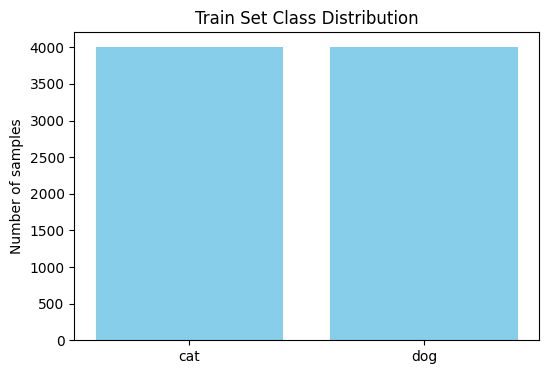

Test Set Class Distribution:
cat: 1011 samples
dog: 1012 samples


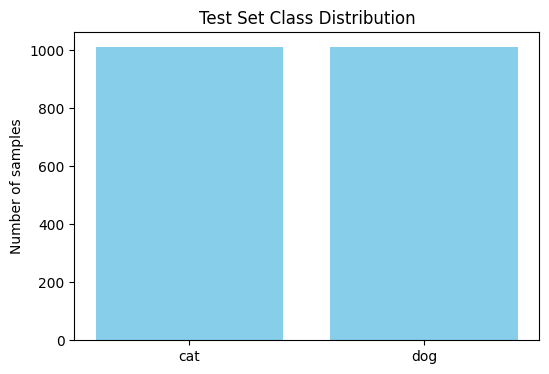

In [ ]:
class_names = ['cat', 'dog']

plot_class_distribution(y_train, class_names, title="Train Set Class Distribution")
plot_class_distribution(y_test, class_names, title="Test Set Class Distribution")


## 2.5 Showing Samples from the Data Set

In [ ]:
def show_sample_images(X, y, class_names=None, samples_per_row=5, total_samples=15, title="Showing Samples from the Data Set"):
    """
    It displays random sample images from the dataset.

    Parametreler:
    X : numpy array or liste
        Images
    y : numpy array or liste
        Labels
    class_names : list, optional
        Label names (['cat','dog'])
    samples_per_row : int
        Number of visuals to display per line
    total_samples : int
       Total number of images to display
    title : str
       title
    """
    plt.figure(figsize=(10, 10))
    indices = random.sample(range(len(X)), total_samples)

    for i, idx in enumerate(indices):
        plt.subplot(total_samples // samples_per_row + 1, samples_per_row, i + 1)
        plt.imshow(cv2.cvtColor(X[idx], cv2.COLOR_BGR2RGB))
        label = y[idx]
        label_name = class_names[label] if class_names else str(label)
        plt.title(label_name)
        plt.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


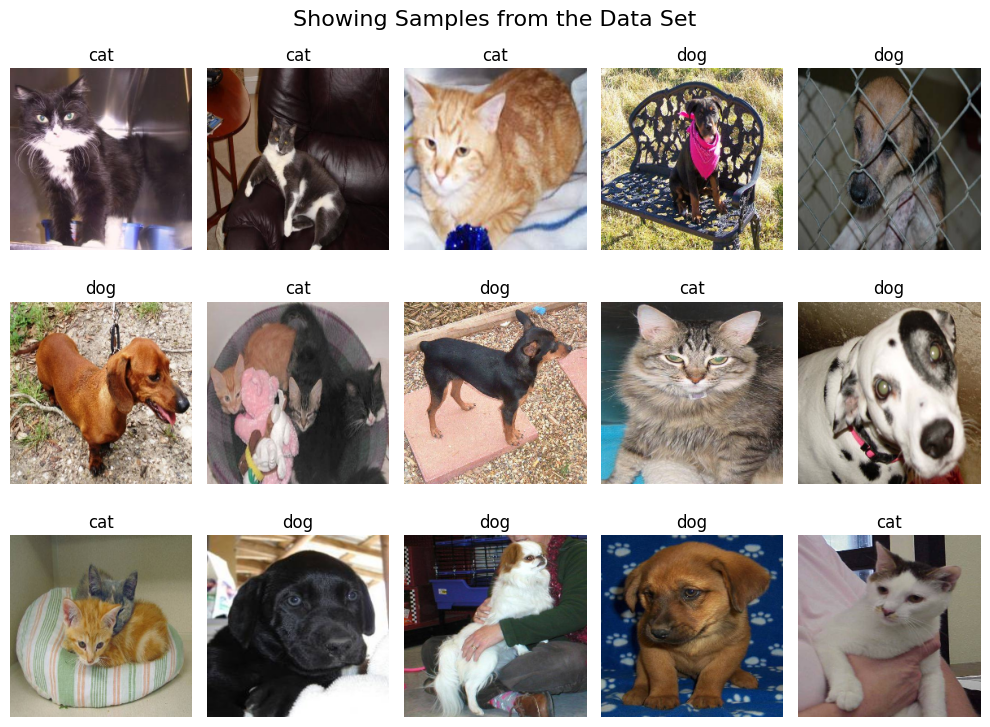

In [ ]:
class_names = ['cat', 'dog']

show_sample_images(x_train, y_train, class_names, samples_per_row=5, total_samples=15)


# 3.Data Preparation - ImageDataGenerator
While preparing the data for modeling, let's make the dataset more realistic by adding some noise to the existing images.

**ImageDataGenerator : Performs real-time data generation and augmentation using techniques such as cropping, rotating, and padding. It also loads data into memory gradually, making the process more efficient.**





In [ ]:
train = ImageDataGenerator(rescale=1./255,
                           validation_split=0.2,
                           rotation_range=25,
                           horizontal_flip=True,
                           vertical_flip=True,
                           shear_range=0.2,
                           zoom_range=0.1,
                           width_shift_range=0.1,
                           height_shift_range=0.1)



test = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train.flow_from_directory(directory=train_dir,
                                            target_size=(target_size),
                                            batch_size=32,
                                            class_mode='binary',
                                            subset='training')# %80 training


validation_generator = train.flow_from_directory(directory=train_dir,
                                                 target_size=(target_size),
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 subset='validation') # subset='validation' %20



test_generator = test.flow_from_directory(directory=test_dir,
                                          target_size=(target_size),
                                          batch_size=64,
                                          shuffle=False,
                                          class_mode='binary')



Found 6404 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


**Training - validation subsets**

* train_generator → takes 80% of the data

* validation_generator → takes 20% of the data

The two generators do not share any images, meaning the data is completely different.

Therefore, during training, the model does not see the validation data.

**Within Keras ImageDataGenerator, the data is sorted and shuffled randomly (shuffle=True by default).**

Then validation_split is applied.


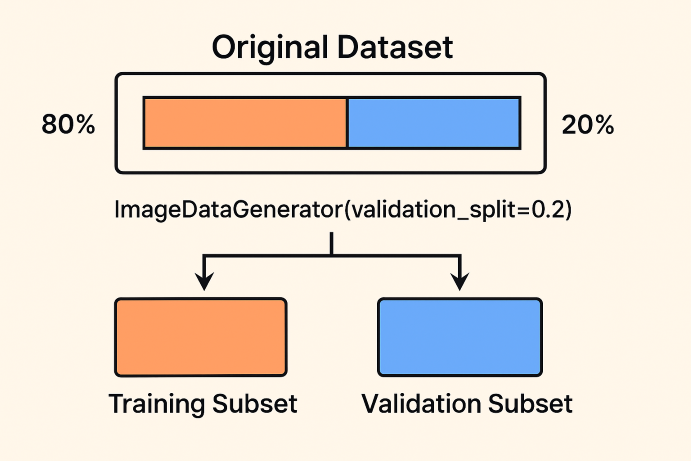


# 4.Modelling

In [ ]:
model = Sequential()

# Convolution Layer
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(input_shape), activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

# We performed feature extraction from the input image using convolutional layers and filters.

# convert to one-dimensional array
model.add(Flatten())

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.35))

model.add(Dense(units=1, activation='sigmoid'))


**The sigmoid activation function produces a single probability value between 0 and 1 for each sample.**

This value is usually interpreted as follows:

Close to 0 → class “0” (e.g., cat)

Close to 1 → class “1” (e.g., dog)

# 5.Model Summary

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,329 (49.36 MB)

 Trainable params: 12,938,945 (49.36 MB)

 Non-trainable params: 384 (1.50 KB)

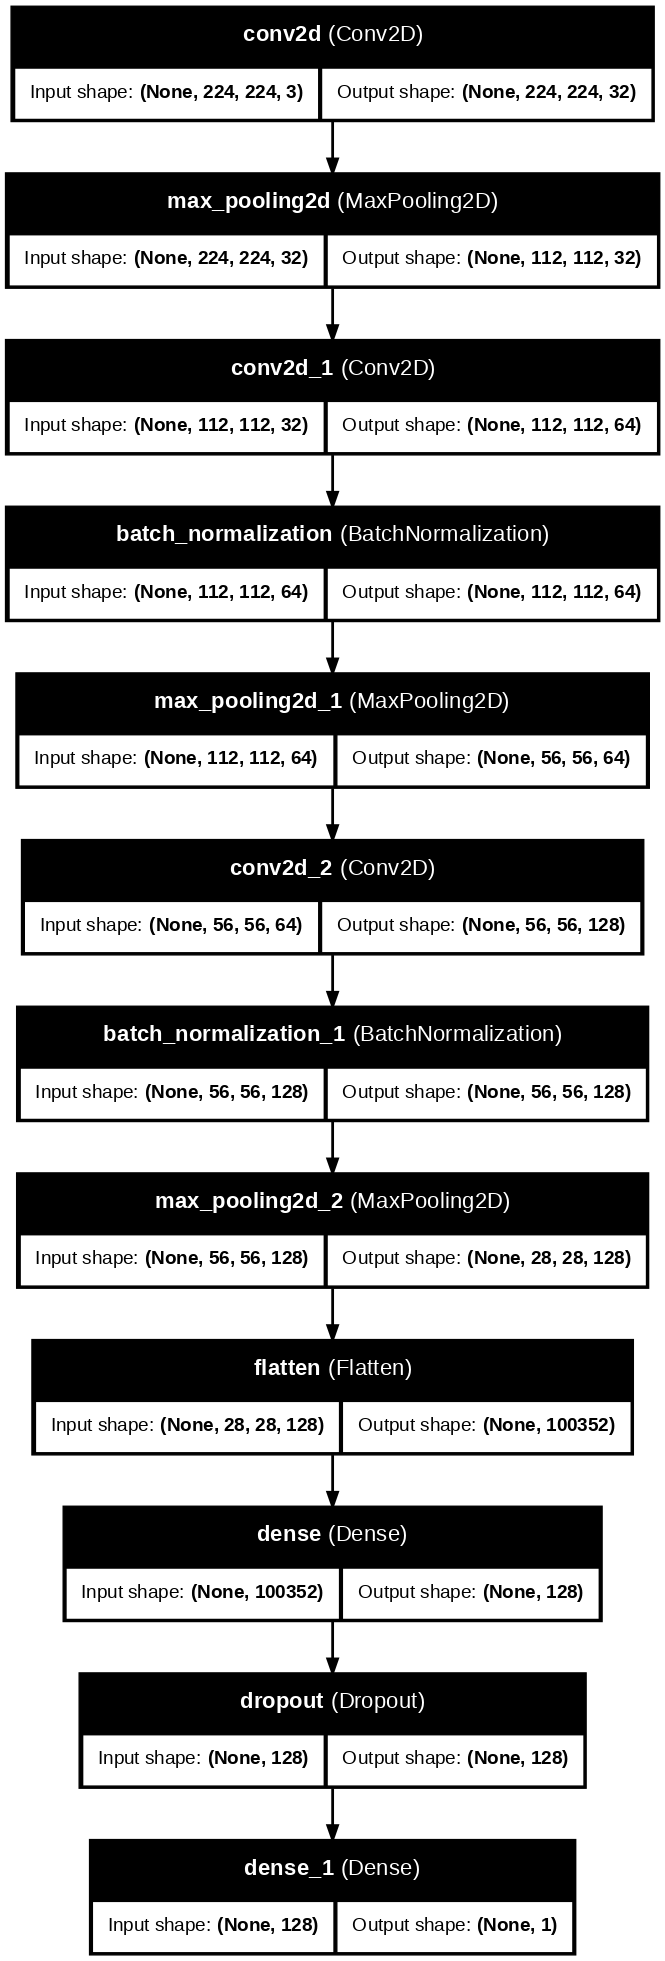

In [ ]:
plot_model(
    model,
    to_file='/content/model_architecture.png',  # Colab için mutlak yol
    show_shapes=True,
    show_layer_names=True,
    dpi=100
)

# 6.Setting Optimization and Evaluation Metrics

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'acc'])

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-7),
             EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min'),
             ModelCheckpoint(filepath='/content/cat-and-dog.keras', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False, verbose=1)]

# 7.Training the Model

In [ ]:
history = model.fit(train_generator,
                              epochs=100,
                              validation_data=validation_generator,
                              callbacks=callbacks)

Epoch 1/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - acc: 0.5273 - loss: 6.2980 - precision: 0.5434 - recall: 0.3986
Epoch 1: val_loss improved from inf to 23.87442, saving model to /content/cat-and-dog.keras
201/201 ━━━━━━━━━━━━━━━━━━━━ 121s 550ms/step - acc: 0.5274 - loss: 6.2792 - precision: 0.5436 - recall: 0.3982 - val_acc: 0.5003 - val_loss: 23.8744 - val_precision: 1.0000 - val_recall: 0.0012 - learning_rate: 0.0010
Epoch 2/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - acc: 0.5462 - loss: 0.6776 - precision: 0.6736 - recall: 0.1864
Epoch 2: val_loss improved from 23.87442 to 8.89685, saving model to /content/cat-and-dog.keras
201/201 ━━━━━━━━━━━━━━━━━━━━ 109s 541ms/step - acc: 0.5463 - loss: 0.6776 - precision: 0.6737 - recall: 0.1867 - val_acc: 0.5384 - val_loss: 8.8968 - val_precision: 0.5465 - val_recall: 0.4544 - learning_rate: 0.0010
Epoch 3/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - acc: 0.5795 - loss: 0.6614 - precision: 0.7579 - recall: 0.2386
Epoch 3: val_l

# 8.Accuracy - Loss - Recall - Precision

In [ ]:
print(history.history.keys())

dict_keys(['acc', 'loss', 'precision', 'recall', 'val_acc', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])


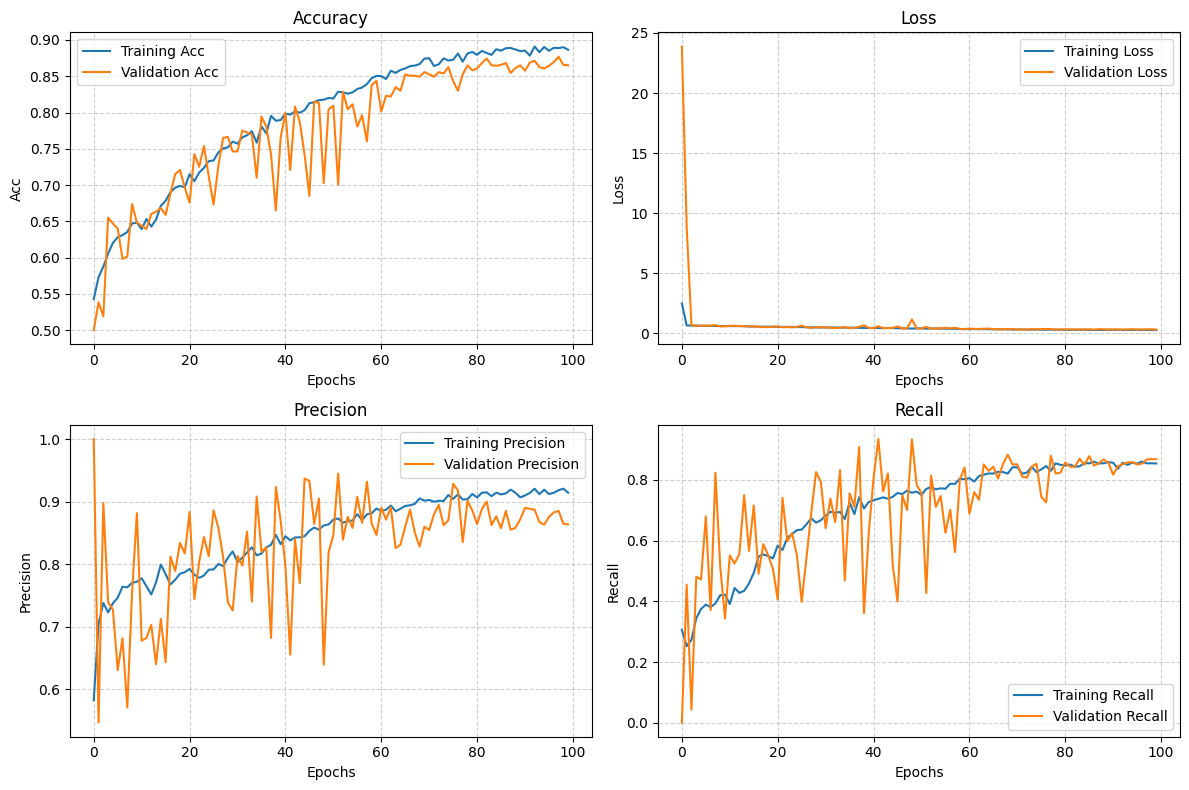

In [ ]:
metrics = ['acc', 'loss', 'precision', 'recall']
titles = ['Accuracy', 'Loss', 'Precision', 'Recall']

plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.plot(history.history[metric], label=f'Training {metric.capitalize()}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
    plt.title(titles[i])
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:

def plot_training_history(history, metrics=None):
    """
    history: model.fit() sonrası dönen History objesi
    metrics: Görselleştirmek istediğin metriklerin listesi.
             Örn: ['loss', 'accuracy', 'precision', 'recall']
             Eğer None ise history içindeki tüm metrikleri çizer.
    """
    if metrics is None:
        # loss dışındaki tüm metrikler
        metrics = [m for m in history.history.keys() if not m.startswith('val_')]

    n = len(metrics)
    plt.figure(figsize=(6*n, 5))

    for i, metric in enumerate(metrics):
        plt.subplot(1, n, i+1)
        # Eğitim metrikleri
        plt.plot(history.history[metric], label=f'Training {metric.capitalize()}')
        # Validasyon metrikleri
        val_metric = f'val_{metric}'
        if val_metric in history.history:
            plt.plot(history.history[val_metric], label=f'Validation {metric.capitalize()}')

        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel(metric.capitalize(), fontsize=12)
        plt.title(f'Training and Validation {metric.capitalize()}', fontsize=14)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

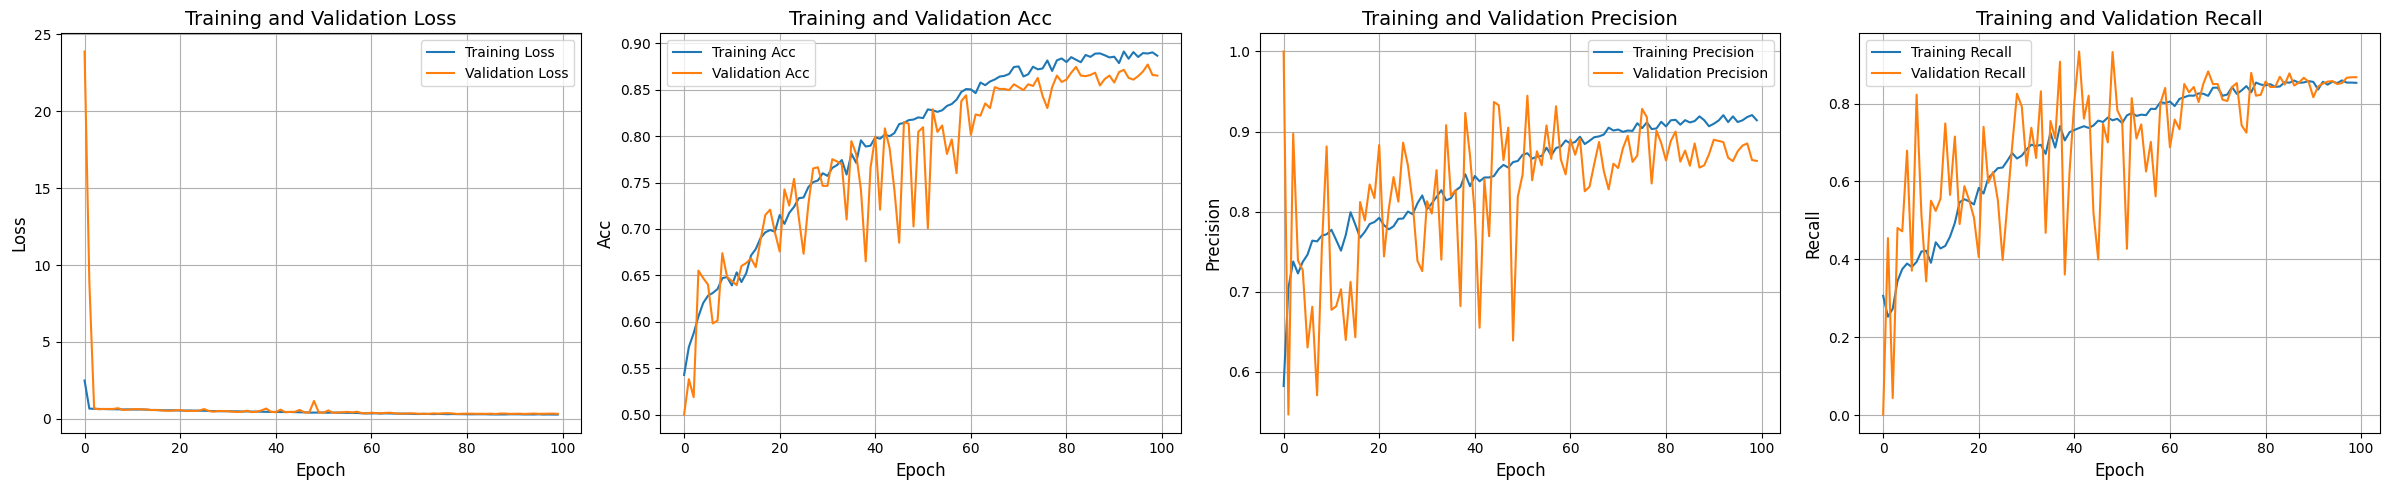

In [ ]:
plot_training_history(history, metrics=['loss', 'acc', 'precision', 'recall'])


# 9.Evaluation

## 9.1 model.evaluate

In [ ]:
loss, precision, recall, acc = model.evaluate(test_generator)

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - acc: 0.8705 - loss: 0.3781 - precision: 0.8510 - recall: 0.9004


Total test image = 2023

batch_size = 64

31(step)*64 + 39 = 2023

steps = 32

**evaluate => 1-31.(step) : 1984 => 32.(step) : 39**

In [ ]:
# results of best model

print(f'\nTest Accuracy: %.1f%%' % (100.0 * acc))
print(f'\nTest Loss: %.1f%%' % (100.0 * loss))
print(f'\nTest Precision: %.1f%%' % (100.0 * precision))
print(f'\nTest Recall: %.1f%%' % (100.0 * recall))


Test Accuracy: 88.2%

Test Loss: 35.1%

Test Precision: 87.1%

Test Recall: 89.7%


## 9.2 Classification Report- Confusion Matrix

In [ ]:
print(test_generator.class_indices)

{'cats': 0, 'dogs': 1}


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step


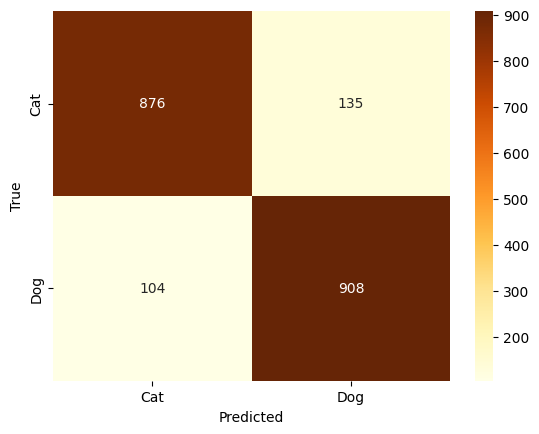

              precision    recall  f1-score   support

        cats       0.89      0.87      0.88      1011
        dogs       0.87      0.90      0.88      1012

    accuracy                           0.88      2023
   macro avg       0.88      0.88      0.88      2023
weighted avg       0.88      0.88      0.88      2023



In [ ]:
y_pred = model.predict(test_generator, steps=len(test_generator))

y_pred_classes = (y_pred > 0.5).astype(int).ravel()  # 0 veya 1 sınıfı

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)

# 4️⃣ Görselleştir
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr',
            xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))


## 9.3 Reloading Saved Model

In [6]:
new_model = tf.keras.models.load_model('/content/cat-and-dog.keras')

new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,817,221 (148.08 MB)

 Trainable params: 12,938,945 (49.36 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 25,877,892 (98.72 MB)

In [ ]:
new_loss, new_precision, new_recall, new_acc = new_model.evaluate(test_generator,steps=len(test_generator))

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - acc: 0.8857 - loss: 0.3888 - precision: 0.3921 - recall: 0.4860


## 9.4 Testing the Model with New Data

In [7]:
# Prediction function (binary classification)
def predict_image(img_path, model):
    """
    Args:
        img_path: Path to the image
        model: Trained Keras model
    """
    img = image.load_img(img_path, target_size=(224,224))
    img_array = image.img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    # Binary classification: single probability value
    probability = float(preds[0][0])
    predicted_class = 'Dog' if probability > 0.5 else 'Cat'

    # Visualisation
    plt.figure(figsize=(4,4))
    plt.axis('off')
    plt.imshow(img_array.squeeze())
    plt.title(f'Predicted Class: {predicted_class}\nProbability: {probability:.2f}')
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


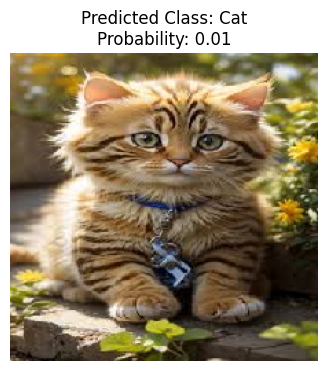

In [8]:
img_path = '/content/cat1.jpg'
predict_image(img_path, new_model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


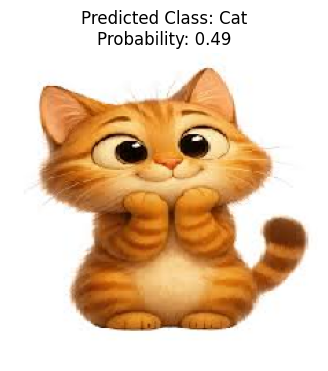

In [9]:
img_path = '/content/cat2.jpg'
predict_image(img_path, new_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


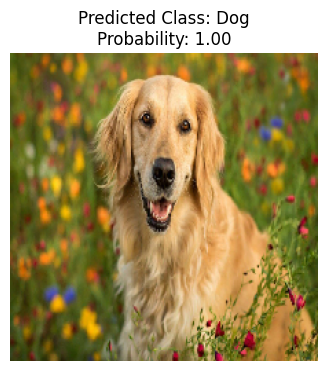

In [10]:
img_path = '/content/dog1.jpg'
predict_image(img_path, new_model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


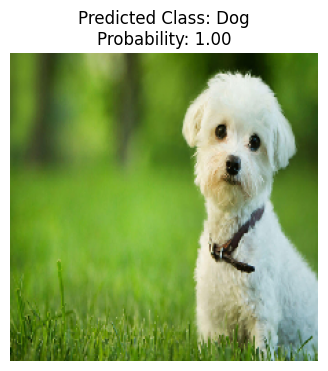

In [11]:
img_path = '/content/dog2.jpg'
predict_image(img_path, new_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


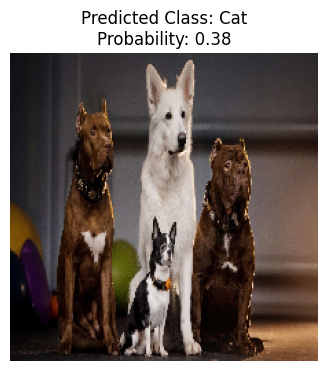

In [12]:
img_path = '/content/dog3.jpg'
predict_image(img_path, new_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


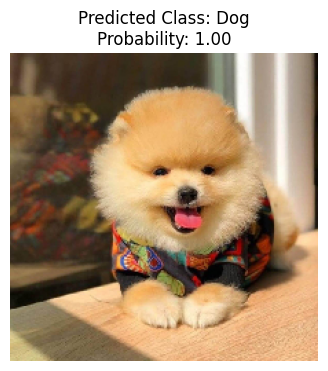

In [13]:
img_path = '/content/dog4.jpg'
predict_image(img_path, new_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


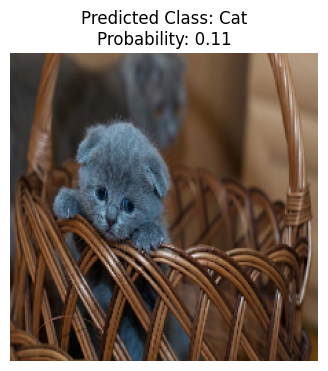

In [14]:
img_path = '/content/cat3.jpg'
predict_image(img_path, new_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


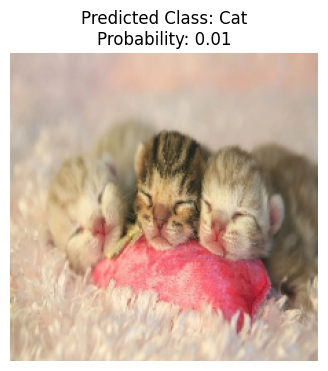

In [15]:
img_path = '/content/cat4.jpg'
predict_image(img_path, new_model)